<a href="https://colab.research.google.com/github/VDuggi/API-Repo/blob/main/nfl_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nfl_data_py
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install sklearn
!pip install xgboost


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.3 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=6495fa561822019360897b760cfbad5ae4225c81e755b7954221f81ca01b8c76
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the p

In [2]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier

In [4]:
pbp = nfl.import_pbp_data([2020, 2021, 2022])

2020 done.
2021 done.
2022 done.
Downcasting floats.


In [6]:
pbp.head(3)

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,...,success,passer,passer_jersey_number,rusher,rusher_jersey_number,receiver,receiver_jersey_number,pass,rush,first_down,special,play,passer_id,rusher_id,receiver_id,name,jersey_number,id,fantasy_player_name,fantasy_player_id,fantasy,fantasy_id,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,nflverse_game_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,None,None,None,None,NaN,2020-09-13,900.0,1800.0,3600.0,Half1,0.0,NaN,0.0,1.0,NaN,0.0,15:00,ARI 35,0.0,NaN,GAME,None,NaN,0.0,0.0,NaN,0.0,0.0,0.0,None,None,NaN,NaN,None,None,None,NaN,None,None,3.0,3.0,NaN,None,...,0.0,None,NaN,None,NaN,None,NaN,0.0,0.0,NaN,0.0,0.0,None,None,None,None,NaN,None,None,None,None,None,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020_01_ARI_SF,,None,None,NaN,None,NaN,,,,0.0,0.0,NaN,NaN,None,None,None,None
1,39.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,ARI,35.0,2020-09-13,900.0,1800.0,3600.0,Half1,0.0,1.0,0.0,1.0,NaN,0.0,15:00,ARI 35,0.0,41.0,5-Z.Gonzalez kicks 65 yards from ARI 35 to end...,kickoff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,NaN,NaN,None,None,None,NaN,None,None,3.0,3.0,0.0,None,...,0.0,None,NaN,None,NaN,None,NaN,0.0,0.0,0.0,1.0,0.0,None,None,None,None,NaN,None,None,None,None,None,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020_01_ARI_SF,ARI,None,None,NaN,None,NaN,45142;46331;46674;45037;46253;44878;42579;4637...,00-0033258;00-0034490;00-0033862;00-0029747;00...,00-0034073;00-0034730;00-0033783;00-0031961;00...,11.0,11.0,NaN,NaN,None,None,None,None
2,54.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,SF,75.0,2020-09-13,900.0,1800.0,3600.0,Half1,0.0,1.0,0.0,1.0,1.0,0.0,15:00,SF 25,10.0,41.0,(15:00) (Shotgun) 10-J.Garoppolo pass short ri...,pass,5.0,1.0,0.0,1.0,0.0,0.0,0.0,short,right,4.0,1.0,None,None,None,NaN,None,None,3.0,3.0,0.0,None,...,1.0,J.Garoppolo,10.0,None,NaN,G.Kittle,85.0,1.0,0.0,1.0,0.0,1.0,00-0031345,None,00-0033288,J.Garoppolo,10.0,00-0031345,G.Kittle,00-0033288,G.Kittle,00-0033288,0.0,1.0,1.294838,0.50337,4.275047,2.0,0.619306,0.239695,0.515058,48.494156,2020_01_ARI_SF,SF,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",4.0,40078;46078;45069;46113;38551;45185;42718;4781...,00-0029892;00-0034847;00-0033221;00-0034860;00...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0,4.19,2.436,False,OUT,MAN_COVERAGE,COVER_1


In [7]:
pbp.describe()

,play_id,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,down,goal_to_go,ydstogo,ydsnet,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,air_yards,yards_after_catch,kick_distance,home_timeouts_remaining,away_timeouts_remaining,timeout,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,...,series_success,order_sequence,play_deleted,special_teams_play,fixed_drive,drive_play_count,drive_first_downs,drive_inside20,drive_ended_with_score,drive_quarter_start,drive_quarter_end,drive_yards_penalized,drive_play_id_started,drive_play_id_ended,away_score,home_score,result,total,spread_line,total_line,div_game,temp,wind,aborted_play,success,passer_jersey_number,rusher_jersey_number,receiver_jersey_number,pass,rush,first_down,special,play,jersey_number,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,defenders_in_box,number_of_pass_rushers,n_offense,n_defense,ngs_air_yards,time_to_throw
count,149373.000000,149373.000000,136669.000000,149365.000000,149365.000000,149365.000000,149373.000000,147828.000000,149373.000000,149373.000000,123405.000000,149373.000000,149373.000000,147828.000000,142659.000000,149373.000000,149373.000000,142786.000000,149373.000000,149373.000000,149373.000000,57604.000000,37300.000000,15473.000000,149373.000000,149373.000000,142659.000000,138224.000000,138224.000000,149373.000000,149373.000000,138224.000000,138224.000000,138224.000000,138224.000000,138224.000000,138224.000000,149373.000000,149373.000000,149373.000000,149373.000000,149373.000000,149373.000000,149373.000000,149373.000000,149373.000000,147697.000000,147697.000000,149373.000000,149373.000000,...,149373.000000,149373.000000,149373.0,149373.000000,149373.000000,147828.000000,147828.000000,147828.000000,147828.000000,147828.000000,147828.000000,147828.000000,147828.000000,147828.000000,149373.000000,149373.000000,149373.000000,149373.000000,149373.000000,149373.000000,149373.000000,50170.000000,50170.000000,149373.000000,147697.000000,67799.000000,44923.000000,58964.000000,149373.000000,149373.000000,142659.000000,149373.000000,149373.000000,109724.000000,149373.000000,149373.000000,147697.000000,51720.000000,51720.000000,51720.000000,51720.000000,51720.000000,112189.000000,109318.000000,109968.000000,63874.000000,147832.000000,147832.000000,54895.000000,56861.000000
mean,2104.511719,9.781467,48.272045,406.526031,798.702209,1696.671875,0.017185,11.512413,0.074424,2.574388,1.984685,0.051529,6.973556,42.583656,4.085743,0.503525,0.077624,0.451039,0.008710,0.001520,0.019977,7.795605,5.132922,42.190460,2.544938,2.529781,0.045521,2.589608,2.604909,12.086864,11.292830,10.676691,12.049463,-1.372772,10.949054,12.058868,-1.109815,0.121494,0.081061,0.001644,0.131066,0.232060,0.002285,0.314264,0.024936,0.001366,1.940609,-0.001400,-0.267650,0.267650,...,0.592443,2103.826660,0.0,0.153080,11.441840,7.687244,2.663778,0.426313,0.498897,2.527119,2.649227,0.378284,2008.299194,2224.268311,22.792051,24.119767,1.327717,46.911818,1.563987,46.340866,0.354656,52.884773,8.737213,0.002109,0.409345,8.648033,24.455669,37.126839,0.453911,0.280961,0.239095,0.149170,0.754648,15.133271,0.087566,0.534441,0.005544,0.725459,5.436650,3.615468,0.781765,0.581852,0.626133,-0.773937,6.363251,4.217240,10.055543,10.053852,7.945738,2.766533
std,1227.619385,5.520021,24.311398,282.596466,563.129272,1060.976318,0.129961,6.620263,0.262461,1.133034,0.998593,0.221074,4.901590,28.914751,7.734719,0.499989,0.267581,0.497599,0.092919,0.038954,0.139921,10.075750,6.520883,11.917764,0.785660,0.798487,0.208445,0.750297,0.714796,10.050971,9.840151,9.5

In [8]:
pbp.value_counts()

Series([], dtype: int64)

In [9]:
print(pbp.shape)
pbp_clean = pbp[(pbp['pass'] ==1) & (pbp['play_type'] != 'no_play')]
print(pbp_clean.shape)

(149373, 390)
(64411, 390)


<function matplotlib.pyplot.show(close=None, block=None)>

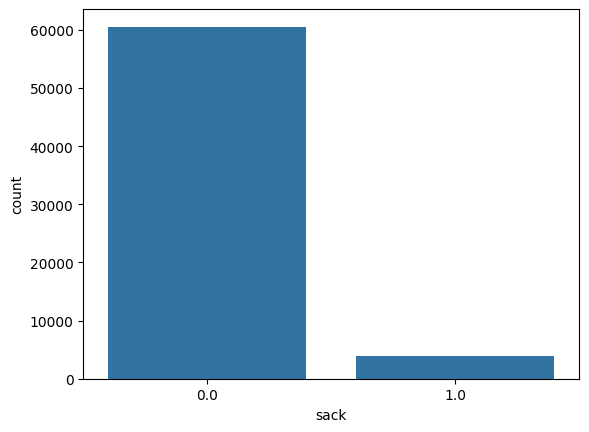

In [10]:
sns.countplot(x = pbp_clean['sack'])
plt.show

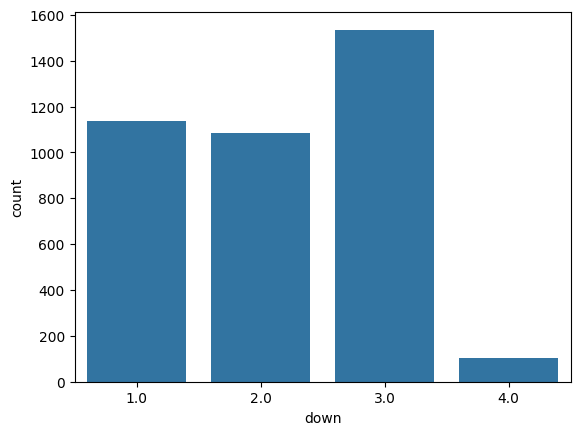

In [11]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks['down'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

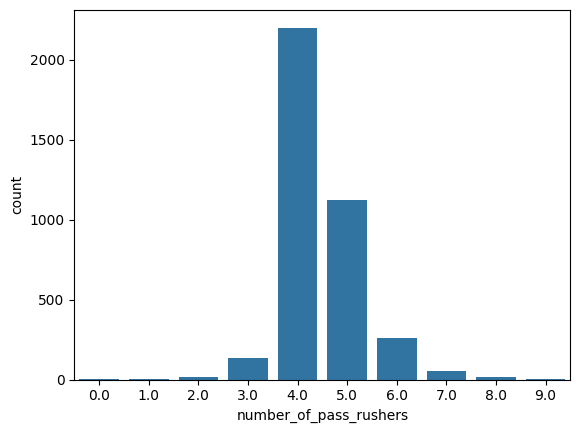

In [13]:
sns.countplot( x= sacks['number_of_pass_rushers'])
plt.show

In [15]:
pbp_clean['obvious_pass'] = np.where((pbp_clean['down'] ==3)& (pbp_clean['ydstogo'] >= 6), 1, 0)

<ipython-input-15-9e954355add7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_clean['obvious_pass'] = np.where((pbp_clean['down'] ==3)& (pbp_clean['ydstogo'] >= 6), 1, 0)


In [20]:
pre_def = pbp_clean[['game_id', 'play_id', 'season', 'name', 'down', 'ydstogo',
                     'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
                     'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack']]

df = pre_def.dropna()
df.isna().sum()

game_id                   0
play_id                   0
season                    0
name                      0
down                      0
ydstogo                   0
yardline_100              0
game_seconds_remaining    0
defenders_in_box          0
number_of_pass_rushers    0
xpass                     0
obvious_pass              0
sack                      0
dtype: int64

In [22]:
df.head()

,game_id,play_id,season,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack
2,2020_01_ARI_SF,54.0,2020,J.Garoppolo,1.0,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0
6,2020_01_ARI_SF,165.0,2020,J.Garoppolo,3.0,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0
9,2020_01_ARI_SF,245.0,2020,K.Murray,1.0,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0
10,2020_01_ARI_SF,274.0,2020,K.Murray,2.0,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0
11,2020_01_ARI_SF,298.0,2020,K.Murray,1.0,10.0,65.0,3360.0,6.0,4.0,0.453060,0,0.0


In [23]:
df['down'] = df['down'].astype('category')
df_no_ids = df.drop(columns = ['game_id', 'play_id', 'name', 'season'])
df_no_ids = pd.get_dummies(df_no_ids, columns = ['down'])


<ipython-input-23-d94badeda5ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['down'] = df['down'].astype('category')


In [24]:
df_no_ids.columns

Index(['ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
       'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack', 'down_1.0',
       'down_2.0', 'down_3.0', 'down_4.0'],
      dtype='object')

In [25]:
df_no_ids.head()

,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack,down_1.0,down_2.0,down_3.0,down_4.0
2,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0,1,0,0,0
6,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0,0,0,1,0
9,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0,1,0,0,0
10,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0,0,1,0,0
11,10.0,65.0,3360.0,6.0,4.0,0.453060,0,0.0,1,0,0,0


In [26]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state= 42)
for train_index, test_index in sss.split(df_no_ids, df_no_ids['sack']):
  strat_train_set = df_no_ids.iloc[train_index]
  strat_test_set = df_no_ids.iloc[test_index]

X_train = strat_train_set.drop(columns = ['sack'])
y_train = strat_train_set['sack']
X_test = strat_test_set.drop(columns = ['sack'])
y_test = strat_test_set['sack']

In [29]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LR_pred = pd.DataFrame(LR.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier score:', brier_score_loss(y_test, LR_pred))


Brier score: 0.05653100198499993


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = pd.DataFrame(rf.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]
print('Brier score: ', brier_score_loss(y_test, rf_pred))

Brier score:  0.059660867845011505


In [32]:
XGB = XGBClassifier(objective='binary:logistic', random_state= 42)
XGB.fit(X_train, y_train)

XGB_pred = pd.DataFrame(XGB.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]
print('Brier score: ', brier_score_loss(y_test, XGB_pred))

Brier score:  0.05729998197946456


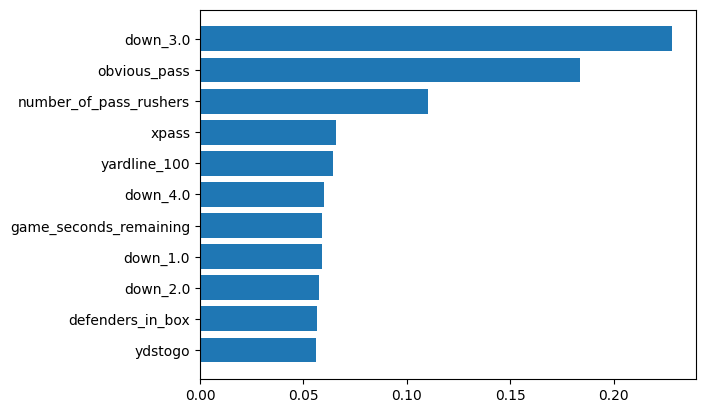

In [34]:
sorted_index = XGB.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_index], XGB.feature_importances_[sorted_index])
plt.show()

In [46]:
make_sacks_preds = df_no_ids.drop('sack', axis = 1)
XGB_total_pred = pd.DataFrame(XGB.predict_proba(make_sacks_preds), columns = ['no_sack', 'sack_pred'])[['sack_pred']]


sacks_preds = df.reset_index().drop(columns = ['index'])
sacks_preds['sack_pred'] = XGB_total_pred

sacks_preds['sacks_oe'] = sacks_preds['sack'] - sacks_preds['sack_pred']
sacks_preds[(sacks_preds['season'] == 2022)].groupby('name').agg({'sack': 'sum', 'sack_pred': 'sum', 'sacks_oe': 'sum'}).reset_index().sort_values('sacks_oe', ascending = True)

,name,sack,sack_pred,sacks_oe
94,T.Brady,24.0,45.566708,-21.566708
51,J.Goff,23.0,39.100056,-16.100058
83,P.Mahomes,29.0,43.495922,-14.495922
100,T.Lawrence,31.0,41.103661,-10.103659
52,J.Herbert,41.0,49.441860,-8.441862
...,...,...,...,...
73,M.Stafford,29.0,19.426132,9.573868
32,D.Jones,52.0,40.757778,11.242221
8,B.Mayfield,36.0,24.288448,11.711552
87,R.Wilson,55.0,35.267677,19.732321


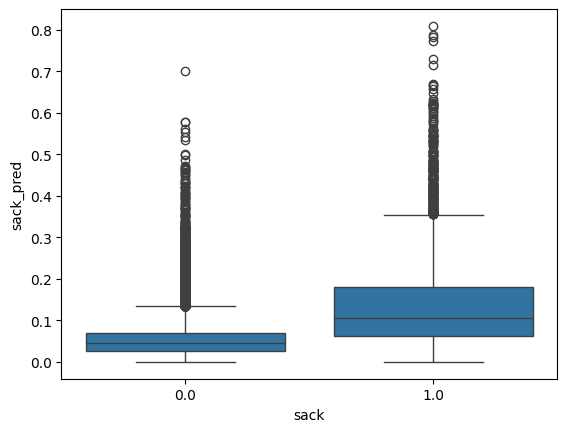

In [47]:
sns.boxplot(x = sacks_preds['sack'], y = sacks_preds['sack_pred'])
plt.show()